In [13]:
%pip install darts
%matplotlib widget

Note: you may need to restart the kernel to use updated packages.


In [14]:
## Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from pytorch_lightning.callbacks import EarlyStopping
from pathlib import Path
import optuna
from tqdm import tqdm
from typing import Dict, Tuple

from darts.metrics import rmse
import warnings
warnings.filterwarnings('ignore')

In [15]:
def load_data(data_dir: str) -> dict:
    data_path = Path(data_dir)
    processed_data = {}

    # Find all parquet files
    parquet_files = list(data_path.glob("**/df*.parquet"))
    print(f"Found {len(parquet_files)} parquet files")

    for file_path in tqdm(parquet_files, desc="Processing cells", unit="cell"):
        # Extract cell number from parent directory name
        file_name = file_path.stem  
        cell_number = file_name.replace('df_', '')  
        cell_name = f'C{cell_number}'  
        tqdm.write(f"Processing {cell_name} ...")
            
        # Load and process data
        data = pd.read_parquet(file_path)
        data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'] = pd.to_datetime(data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'])
        
        # Select relevant columns
        data = data[['Absolute_Time[yyyy-mm-dd hh:mm:ss]', 'Current[A]', 'Voltage[V]', 
                    'Temperature[°C]', 'SOH_ZHU']]
        
        # Resample to hourly
        data.set_index('Absolute_Time[yyyy-mm-dd hh:mm:ss]', inplace=True)
        data_hourly = data.resample('h').mean().reset_index()
        
        # Fill missing values
        data_hourly.interpolate(method='linear', inplace=True)
        data_hourly['SOH_ZHU'] = data_hourly['SOH_ZHU'].fillna(1)
        
        # Convert to time series
        target_series = TimeSeries.from_dataframe(
            data_hourly, 'Absolute_Time[yyyy-mm-dd hh:mm:ss]', 'SOH_ZHU'
        )
        covariates = TimeSeries.from_dataframe(
            data_hourly, 'Absolute_Time[yyyy-mm-dd hh:mm:ss]', 
            ['Current[A]', 'Voltage[V]', 'Temperature[°C]']
        )
        
        # Time align
        target_series, covariates = target_series.slice_intersect(covariates), covariates.slice_intersect(target_series)
        
        # Scale covariates
        scaler = Scaler(scaler=MinMaxScaler(feature_range=(-1,1)))
        covariates_scaled = scaler.fit_transform(covariates)
        
        processed_data[cell_name] = {
            'target': target_series,
            'covariates_scaled': covariates_scaled
        }
    
    return processed_data

data_dir = "../01_Datenaufbereitung/Output/Calculated/"
processed_data = load_data(data_dir)

Found 15 parquet files


Processing cells:   0%|          | 0/15 [00:00<?, ?cell/s]

Processing C01 ...


Processing cells:   7%|▋         | 1/15 [00:13<03:02, 13.07s/cell]

Processing C03 ...


Processing cells:  13%|█▎        | 2/15 [00:19<01:59,  9.22s/cell]

Processing C05 ...


Processing cells:  20%|██        | 3/15 [00:25<01:33,  7.83s/cell]

Processing C07 ...


Processing cells:  27%|██▋       | 4/15 [00:32<01:19,  7.24s/cell]

Processing C09 ...


Processing cells:  33%|███▎      | 5/15 [00:35<00:57,  5.79s/cell]

Processing C11 ...


Processing cells:  40%|████      | 6/15 [00:38<00:45,  5.00s/cell]

Processing C13 ...


Processing cells:  47%|████▋     | 7/15 [00:40<00:30,  3.83s/cell]

Processing C15 ...


Processing cells:  53%|█████▎    | 8/15 [00:42<00:22,  3.20s/cell]

Processing C17 ...


Processing cells:  60%|██████    | 9/15 [00:47<00:23,  3.99s/cell]

Processing C19 ...


Processing cells:  67%|██████▋   | 10/15 [00:53<00:22,  4.53s/cell]

Processing C21 ...


Processing cells:  73%|███████▎  | 11/15 [00:59<00:19,  4.85s/cell]

Processing C23 ...


Processing cells:  80%|████████  | 12/15 [01:05<00:15,  5.18s/cell]

Processing C25 ...


Processing cells:  87%|████████▋ | 13/15 [01:08<00:09,  4.77s/cell]

Processing C27 ...


Processing cells:  93%|█████████▎| 14/15 [01:14<00:05,  5.01s/cell]

Processing C29 ...


Processing cells: 100%|██████████| 15/15 [01:18<00:00,  5.21s/cell]


In [31]:
def inspect_data_ranges(data_dict: dict):
   """
   Inspect time ranges and value ranges for each battery in the data dictionary
   """
   for cell_name, cell_data in data_dict.items():
       print(f"\n=== {cell_name} ===")
       
       # Get target data range
       target = cell_data['target']
       target_values = target.values().flatten()  # Flatten array for calculation
       print("\nTarget (SOH_ZHU):")
       print(f"Time Range: {target.start_time()} to {target.end_time()}")
       print(f"Value Range: {target_values.min():.4f} to {target_values.max():.4f}")
       print(f"Number of Data Points: {len(target)}")
       
       # Get covariates data range
       covariates = cell_data['covariates_scaled']
       cov_values = covariates.values()
       print("\nCovariates (scaled):")
       for i, feature in enumerate(covariates.components):
           values = cov_values[:, i].flatten()
           print(f"{feature}:")
           print(f"Value Range: {values.min():.4f} to {values.max():.4f}")

# View all data ranges
print("All Data Ranges:")
inspect_data_ranges(processed_data)

All Data Ranges:

=== C01 ===

Target (SOH_ZHU):
Time Range: 2023-02-02 09:00:00 to 2023-09-16 07:00:00
Value Range: 0.9225 to 1.0000
Number of Data Points: 5423

Covariates (scaled):
Current[A]:
Value Range: -1.0000 to 1.0000
Voltage[V]:
Value Range: -1.0000 to 1.0000
Temperature[°C]:
Value Range: -1.0000 to 1.0000

=== C03 ===

Target (SOH_ZHU):
Time Range: 2023-02-02 09:00:00 to 2023-08-17 10:00:00
Value Range: 0.9206 to 1.0000
Number of Data Points: 4706

Covariates (scaled):
Current[A]:
Value Range: -1.0000 to 1.0000
Voltage[V]:
Value Range: -1.0000 to 1.0000
Temperature[°C]:
Value Range: -1.0000 to 1.0000

=== C05 ===

Target (SOH_ZHU):
Time Range: 2023-02-02 09:00:00 to 2023-08-13 12:00:00
Value Range: 0.9172 to 1.0000
Number of Data Points: 4612

Covariates (scaled):
Current[A]:
Value Range: -1.0000 to 1.0000
Voltage[V]:
Value Range: -1.0000 to 1.0000
Temperature[°C]:
Value Range: -1.0000 to 1.0000

=== C07 ===

Target (SOH_ZHU):
Time Range: 2023-02-02 09:00:00 to 2023-08-13 14

In [39]:
def split_cell_data(processed_data: dict, n_train=9, n_val=3, n_test=3) -> Tuple[Dict, Dict, Dict]:
   # Get all cell numbers
   cell_names = list(processed_data.keys())
   
   # Randomly shuffle cell order
   np.random.seed(773)
   np.random.shuffle(cell_names)
   
   # Split cell numbers
   train_cells = cell_names[:n_train]
   val_cells = cell_names[n_train:n_train + n_val]
   test_cells = cell_names[:n_test]
   
   # Create dataset dictionaries
   train_data = {cell: processed_data[cell] for cell in train_cells}
   val_data = {cell: processed_data[cell] for cell in val_cells}
   test_data = {cell: processed_data[cell] for cell in test_cells}
   
   print(f"Data split completed:")
   print(f"Training set: {len(train_data)} cells {sorted(train_cells)}")
   print(f"Validation set: {len(val_data)} cells {sorted(val_cells)}")
   print(f"Test set: {len(test_data)} cells {sorted(test_cells)}")
   
   return train_data, val_data, test_data

# Usage example:
train_data, val_data, test_data = split_cell_data(processed_data)
inspect_data_ranges(train_data)

Data split completed:
Training set: 9 cells ['C01', 'C03', 'C05', 'C09', 'C11', 'C13', 'C17', 'C27', 'C29']
Validation set: 3 cells ['C07', 'C15', 'C21']
Test set: 3 cells ['C03', 'C09', 'C17']

=== C03 ===

Target (SOH_ZHU):
Time Range: 2023-02-02 09:00:00 to 2023-08-17 10:00:00
Value Range: 0.9206 to 1.0000
Number of Data Points: 4706

Covariates (scaled):
Current[A]:
Value Range: -1.0000 to 1.0000
Voltage[V]:
Value Range: -1.0000 to 1.0000
Temperature[°C]:
Value Range: -1.0000 to 1.0000

=== C09 ===

Target (SOH_ZHU):
Time Range: 2023-02-02 09:00:00 to 2023-05-23 08:00:00
Value Range: 0.6815 to 1.0000
Number of Data Points: 2640

Covariates (scaled):
Current[A]:
Value Range: -1.0000 to 1.0000
Voltage[V]:
Value Range: -1.0000 to 1.0000
Temperature[°C]:
Value Range: -1.0000 to 1.0000

=== C17 ===

Target (SOH_ZHU):
Time Range: 2023-02-02 09:00:00 to 2023-08-12 18:00:00
Value Range: 0.7191 to 1.0000
Number of Data Points: 4594

Covariates (scaled):
Current[A]:
Value Range: -1.0000 to 1

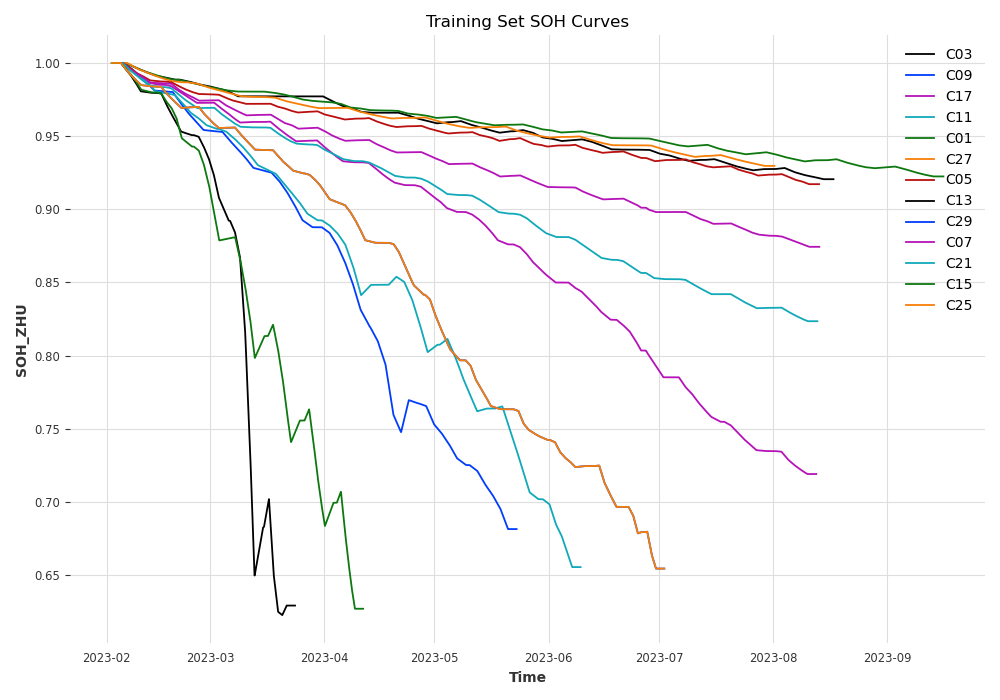

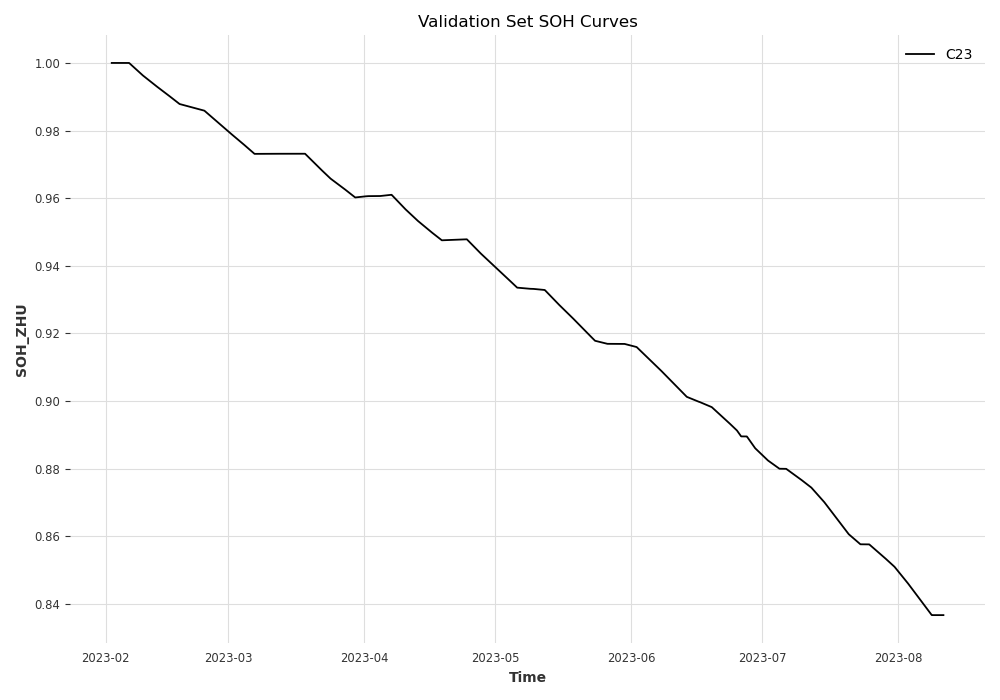

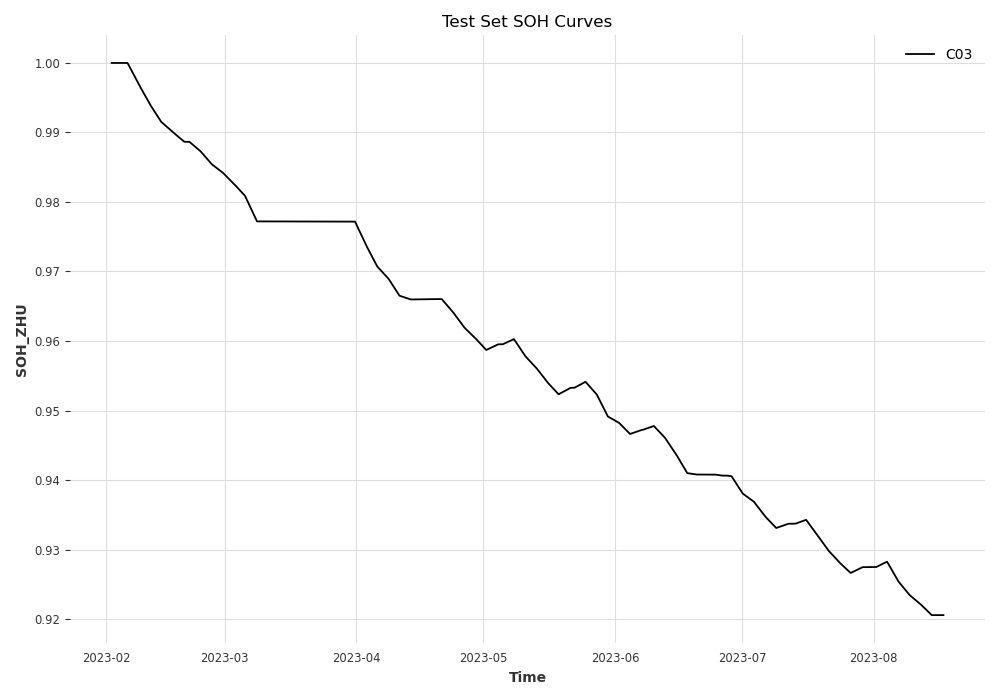

In [18]:
def plot_dataset_soh(data_dict: dict, title: str, figsize=(10, 7)):
    plt.figure(figsize=figsize)
    
    # Plot each cell's SOH
    for cell_name, cell_data in data_dict.items():
        target = cell_data['target']
        plt.plot(target.time_index, target.values().flatten(), label=cell_name)
    
    plt.title(f'{title} Set SOH Curves')
    plt.xlabel('Time')
    plt.ylabel('SOH_ZHU')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# Plot all three datasets
plot_dataset_soh(train_data, "Training")
plot_dataset_soh(val_data, "Validation")
plot_dataset_soh(test_data, "Test")

In [19]:
def prepare_data(data):
    targets = []
    covariates = []
    for cell_data in data.values():
        targets.append(cell_data['target'])
        covariates.append(cell_data['covariates_scaled'])
    
    series = targets[0]
    cov = covariates[0]
    for i in range(1, len(targets)):
        series = series.concatenate(targets[i], ignore_time_axis=True)
        cov = cov.concatenate(covariates[i], ignore_time_axis=True)
    return series, cov

In [20]:
# Optuna objective function
def objective(trial):
    # Define hyperparameter search space
    # 1. Search - Basic structure
    input_chunk_length = trial.suggest_int("input_chunk_length", 12, 36)
    output_chunk_length = trial.suggest_int("output_chunk_length", 1, 24)
    num_blocks = trial.suggest_int("num_blocks", 2, 5)
    num_stacks = trial.suggest_int("num_stacks", 2, 5)
    activation = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU"])
    # 2. Search - Training parameters
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)

    expansion_coefficient_dim = trial.suggest_int("expansion_coefficient_dim", 8, 32, step=8)
    trend_polynomial_degree = trial.suggest_int("trend_polynomial_degree", 1, 3)

    # Define and train model
    model = NBEATSModel(
        input_chunk_length=input_chunk_length,
        output_chunk_length=output_chunk_length,
        num_blocks=num_blocks,
        num_stacks=num_stacks,
        batch_size=batch_size,
        expansion_coefficient_dim=expansion_coefficient_dim, 
        trend_polynomial_degree=trend_polynomial_degree, 
        optimizer_kwargs={"lr": learning_rate},
        random_state=773,
        activation = activation,
        pl_trainer_kwargs={
            "accelerator": "gpu",
            "devices": 1, 
            "callbacks": [
              ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1),
              EarlyStopping(monitor="val_loss", patience=20, mode="min")
            ],
            "enable_checkpointing": True
        }
    )
    train_series, train_cov = prepare_data(train_data)
    val_series, val_cov = prepare_data(val_data)
    
    model.fit(series=train_series, past_covariates=train_cov, 
              val_series=val_series, val_past_covariates=val_cov, epochs=100)  
    
    # Retrieve best validation loss directly from the training process
    best_val_loss = model.trainer.checkpoint_callback.best_model_score.item() 
    
    return best_val_loss



In [ ]:
# Optuna call with progress bar
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)  

# Best trial
print("Best trial:")
trial = study.best_trial
print(f"  Value (MAE): {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

In [21]:
best_params = {'input_chunk_length': 33, 
               'output_chunk_length': 1, 
               'num_blocks': 4, 
               'num_stacks': 3, 
               'activation': 'LeakyReLU', 
               'batch_size': 32, 
               'learning_rate': 0.00041328603854847963,
               "expansion_coefficient_dim":16,
               "trend_polynomial_degree":2
               }

best_model = NBEATSModel(
    input_chunk_length=best_params["input_chunk_length"],
    output_chunk_length=best_params["output_chunk_length"],
    num_blocks=best_params["num_blocks"],
    num_stacks=best_params["num_stacks"],
    batch_size=best_params["batch_size"],
    expansion_coefficient_dim=best_params["expansion_coefficient_dim"],  
    trend_polynomial_degree=best_params["trend_polynomial_degree"],  
    optimizer_kwargs={"lr": best_params["learning_rate"]},  
    random_state=773,  
    activation=best_params["activation"],
    pl_trainer_kwargs={ 
        "accelerator": "gpu",
        "devices": 1,
        "callbacks": [
            ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1),
            EarlyStopping(monitor="val_loss", patience=15, mode="min")
        ],
        "enable_checkpointing": True
    }
)

train_series, train_cov = prepare_data(train_data)
val_series, val_cov = prepare_data(val_data)
best_model.fit(series=train_series, past_covariates=train_cov, 
               val_series=val_series, val_past_covariates=val_cov, epochs=500, verbose=True)

best_model.save('best_nbeats_model')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 2.9 M  | train
-------------------------------------------------------------
2.9 M     Trainable params
6.4 K     Non-trainable params
2.9 M     Total params
11.614    Total estimated model params size (MB)
144       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [22]:
def prepare_test_data(data):
    series = []
    cov = []
    for cell_data in data.values():
        series.append(cell_data['target'])
        cov.append(cell_data['covariates_scaled'])
    return series, cov

In [35]:
def prdictions(model_path:str, test_data):
    model = NBEATSModel.load(model_path)

    test_series, test_cov = [], []
    for cell_data in test_data.values():
        test_series.append(cell_data['target'])
        test_cov.append(cell_data['covariates_scaled'])
        
    start = model.input_chunk_length + model.output_chunk_length
    pred_test = model.historical_forecasts(
        series=test_series,
        past_covariates=test_cov,
        start=start,
        forecast_horizon=model.output_chunk_length,
        retrain=False,
        verbose=True
    )

    backtest_rmse = rmse(test_series, pred_test)
    print(f'Backtest RMSE of Testdaten = {backtest_rmse}')
    
    cell_ids = test_data.keys()  
    colors = ['blue', 'green', 'red']

    plt.figure(figsize=(12, 6))
    for i, (cell_id, pred) in enumerate(zip(cell_ids, pred_test)):
        pred.plot(label=f'{cell_id} Forecast', 
                    color=colors[i], 
                    linestyle='--')
    
        test_data[cell_id]['target'].plot(label=f'{cell_id} Actual', 
                                            color=colors[i], 
                                            linestyle='-',
                                            alpha=0.7)

    plt.title("SOH Forecast vs Actual")    
    plt.xlabel("Time")
    plt.ylabel("SOH")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Backtest RMSE of Testdaten = [0.0006916159941447118, 0.0011337098814419412, 0.0009457240583287241]


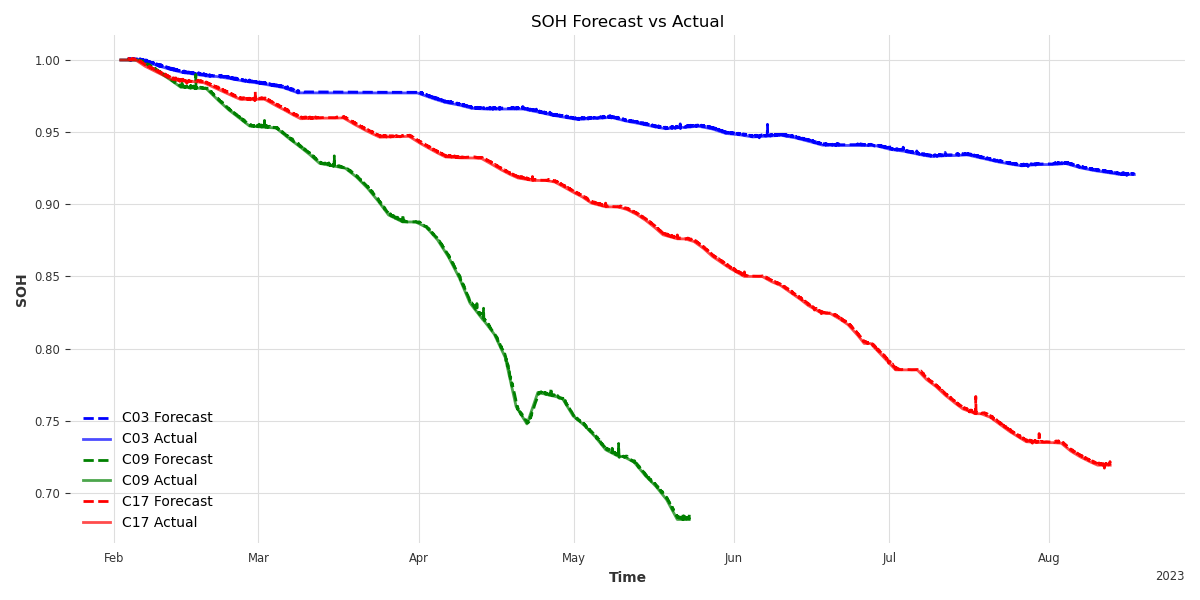

In [40]:
model_path = r'best\02\val1test1\best_nbeats_model'
# model_path = 'best_nbeats_model'

prdictions(model_path, test_data)
